<a href="https://colab.research.google.com/github/Hong-Hyun-Seung/upstage-basic-deeplearning/blob/main/MRC_Practice_4_TF_IDF_Passage_Retrieval_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4강) TF-IDF를 활용한 Passage Retrieval 실습

### Requirements

In [1]:
!pip install datasets
!pip install transformers

## 데이터셋 준비

KorQuAD train 데이터셋을 search corpus로 활용

In [2]:
from datasets import load_dataset

dataset = load_dataset("squad_kor_v1")

Reusing dataset squad_kor_v1 (/root/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/18d4f44736b8ee85671f63cb84965bfb583fa0a4ff2df3c2e10eee9693796725)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 60407
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5774
    })
})

In [4]:
dataset["train"]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 60407
})

In [5]:
dataset["train"][0]

{'answers': {'answer_start': [54], 'text': ['교향곡']},
 'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 'id': '6566495-0-0',
 'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 'title': '파우스트_서곡'}

In [6]:
corpus = list(set([example['context'] for example in dataset['train']]))
len(corpus)

9606

## 토크나이저 준비

가장 기본적인 띄워쓰기를 기준으로 token을 나누는 tokenizer를 활용 (성능 향상을 위해 더 세밀한 토크나이저 활용 가능)

In [7]:
tokenizer_func = lambda x: x.split(' ')

In [8]:
tokenizer_func(corpus[0])[:10]

['예시에서', '볼', '수', '있다시피,', '독립', '변수는', '실제', '값,', '이진', '값,']

## TF-IDF embedding 만들기

Scikit-learn의 TfidfVectorizer를 활용하여 TF-IDF embedding 만들어보기 
(unigram, bigram 활용)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenizer_func, ngram_range=(1,2))

### 문서 전체에 등장하는 term들을 다 vocab으로 만들어줘야 한다-> fit이라는 표현을 쓴다

In [10]:
vectorizer.fit(corpus)
sp_matrix = vectorizer.transform(corpus)# 이 부분은 실제로 corpus를 바꿔준다 (vectorizer에 맞춰서 sparse matrix로)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [11]:
sp_matrix.shape

(9606, 1272768)

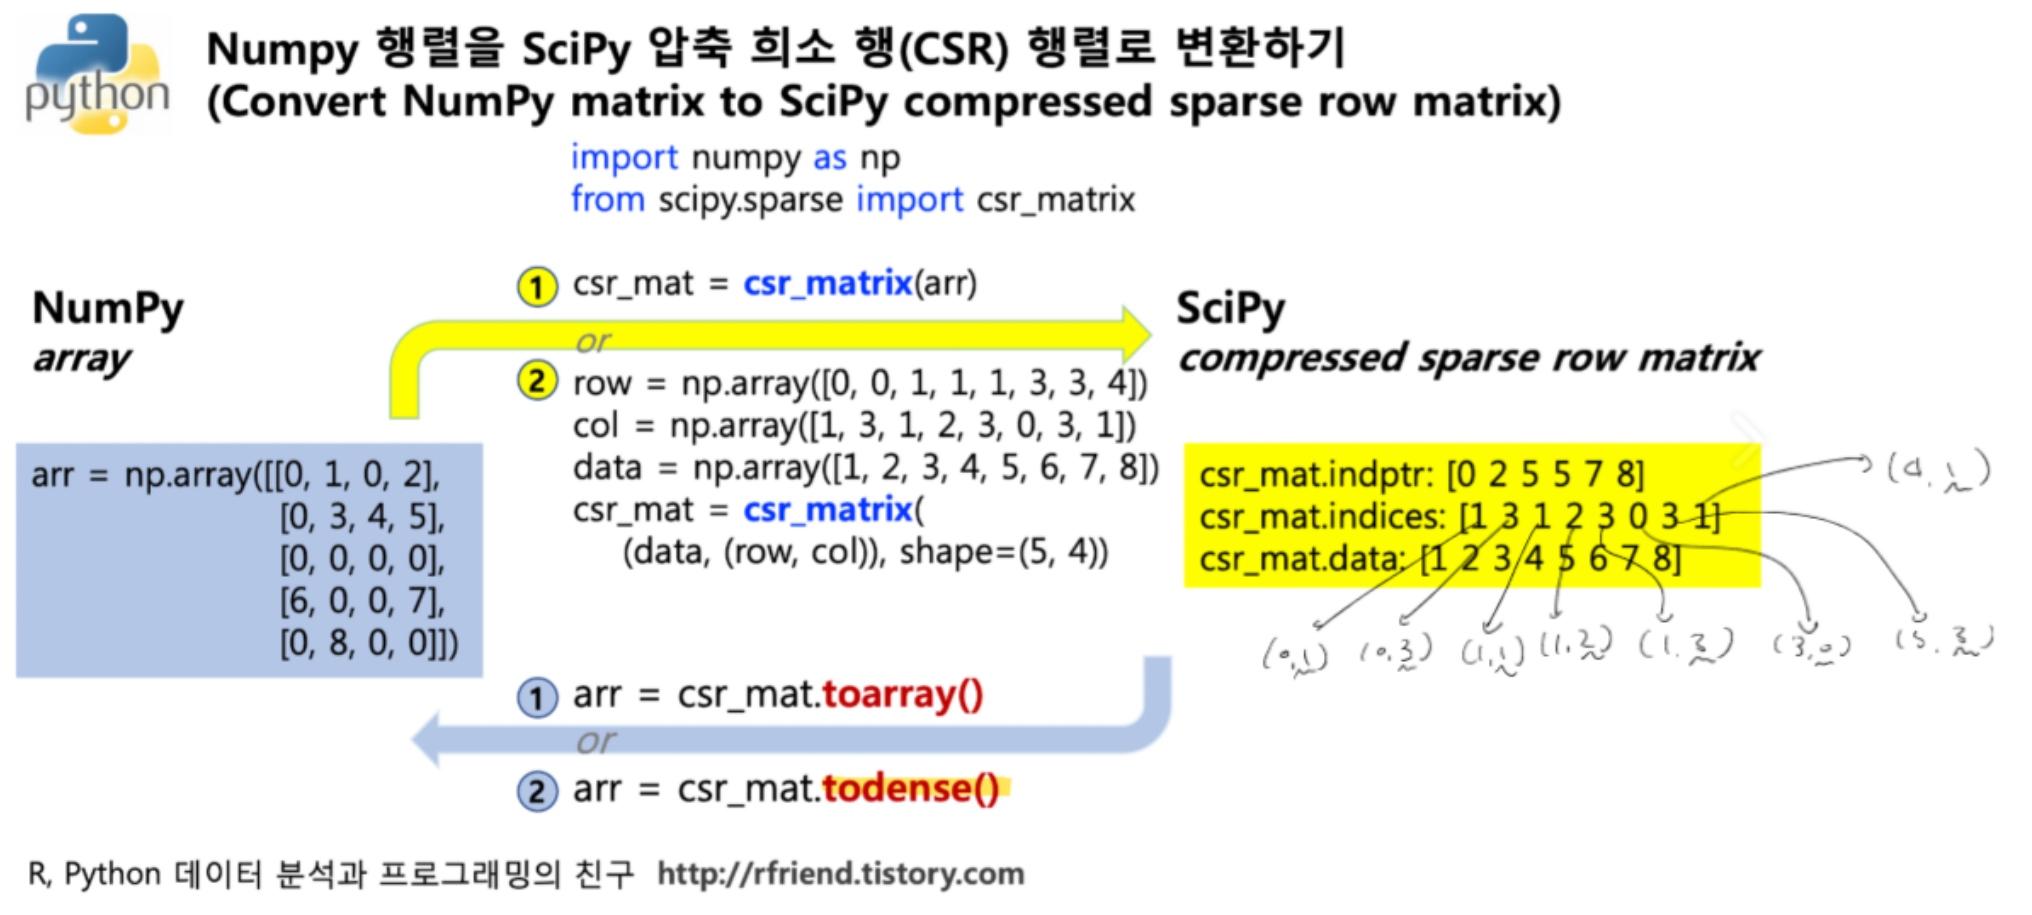

In [13]:
import pandas as pd
temp = pd.DataFrame(sp_matrix)

In [14]:
import pandas as pd
df = pd.DataFrame(sp_matrix[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print(df.head(10))

            TF-IDF
값을        0.208827
해당 변수가    0.133764
값,        0.133764
구분된       0.133764
로지스틱      0.128041
로지스틱 회귀를  0.128041
이산        0.128041
회귀를       0.123980
변수가       0.118257
특정        0.115048


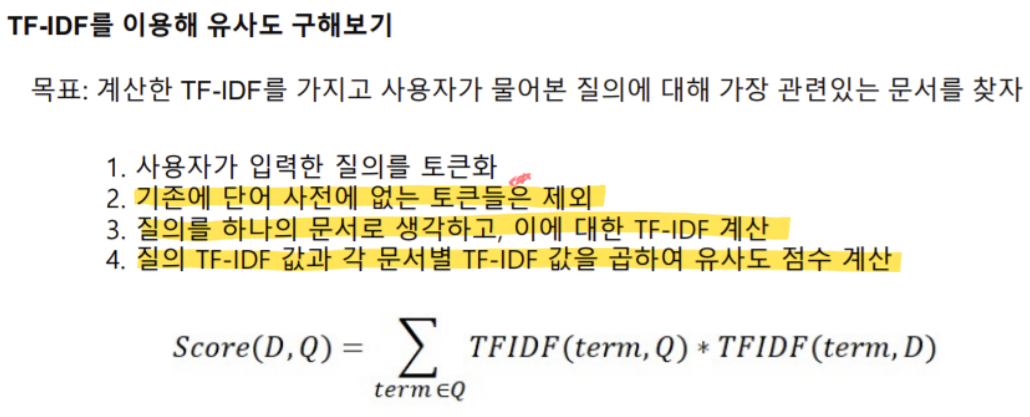

## TF-IDF embedding을 활용하여 passage retrieval 실습해보기

앞서 만든 sparse embedding을 활용하여, 실제 passage retrieval 수행해보기

Search query로 KorQuAD train 데이터셋의 질문을 활용하여, 실제 context가 잘 나오는지 확인해보기

In [15]:
import random
import numpy as np

random.seed(1)
sample_idx = random.choice(range(len(dataset['train'])))

query = dataset['train'][sample_idx]['question']
ground_truth = dataset['train'][sample_idx]['context']

Query를 tf-idf vector로 변환

In [16]:
query_vec = vectorizer.transform([query])

In [19]:
query_vec.shape #밑에 shape을 보면, 그냥 사실상 query_vec이 벡터임을 알수 있다
#여기까지가 위에 markdown에서 1,2,3번과정 수행한것

(1, 1272768)

변환된 query vector를 document들의 vector과 dot product를 수행 => Document들의 similarity ranking을 구함

In [18]:
result = query_vec * sp_matrix.T
result.shape #각각의 지문과 현재 쿼리의 유사도를 벡터로 나타낸것

(1, 9606)

In [20]:
sorted_result = np.argsort(-result.data)
doc_scores = result.data[sorted_result]
doc_ids = result.indices[sorted_result]

Top-3개의 passage를 retrieve 하고, 실제 ground_truth와 비교해보기

In [21]:
k = 3
doc_scores[:k], doc_ids[:k]

(array([0.18985967, 0.03625019, 0.03371167]),
 array([6000,   44,  163], dtype=int32))

In [23]:
print("[Search query]\n", query, "\n")

print("[Ground truth passage]")
print(ground_truth, "\n")

for i in range(k):
  print("Top-%d passage with score %.4f" % (i + 1, doc_scores[i]))
  doc_id = doc_ids[i]
  print(corpus[doc_id], "\n")


[Search query]
 호메로스 찬가를 신통기에 비해 간결한 서사로 간주한 사람은 누구인가? 

[Ground truth passage]
고전 시대 신화에서는 티탄들의 패배 이후, 신들의 새로운 판테온이 세워졌다고 설명한다. 주요한 그리스 신들 중에서 올림피안은 올림포스 산 정상에서 제우스의 통치 아래 살아가는 신들을 말한다. 이들의 인원이 열두 명으로 제한된 것은 비교적 최근에 도입된 개념으로 보인다. 올림피안 이외에도 그리스인들은 염소 신 판, 강의 정령 님프, 샘에 사는 나이아드, 나무의 정령 드라이어드, 바다에 사는 네레이드, 강의 신, 사티로스를 비롯한 그 지역의 다양한 신들을 숭배하였다. 여기에는 에리니에스(또는 푸리아이)처럼 혈연 관계에게 범죄를 저지른 죄인을 뒤쫓는 저승의 암흑 세력도 있었다. 시인들은 그리스 판테온의 영광을 기리고자 호메로스 찬가를 지었다.(33편의 노래). 그레고리 나지는 호메로스 찬가를 "각 노래마다 신에 대한 기원을 노래하는(《신통기》에 비해) 간결한 서가"로 간주하였다. 

Top-1 passage with score 0.1899
고전 시대 신화에서는 티탄들의 패배 이후, 신들의 새로운 판테온이 세워졌다고 설명한다. 주요한 그리스 신들 중에서 올림피안은 올림포스 산 정상에서 제우스의 통치 아래 살아가는 신들을 말한다. 이들의 인원이 열두 명으로 제한된 것은 비교적 최근에 도입된 개념으로 보인다. 올림피안 이외에도 그리스인들은 염소 신 판, 강의 정령 님프, 샘에 사는 나이아드, 나무의 정령 드라이어드, 바다에 사는 네레이드, 강의 신, 사티로스를 비롯한 그 지역의 다양한 신들을 숭배하였다. 여기에는 에리니에스(또는 푸리아이)처럼 혈연 관계에게 범죄를 저지른 죄인을 뒤쫓는 저승의 암흑 세력도 있었다. 시인들은 그리스 판테온의 영광을 기리고자 호메로스 찬가를 지었다.(33편의 노래). 그레고리 나지는 호메로스 찬가를 "각 노래마다 신에 대한 기원을 노래하는(《신통기》에 비해) 간결한 서가"로 간주하였다. 

Top-2 